In [1]:
from torch.utils.data import Dataset
from torch.nn import init
import torch.nn as nn
import torchaudio
import torch

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
import soundfile

In [2]:
# find the device available for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# class with audio utility functions for loading, augmenting and transforming audio files
class AudioUtil:
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        signal_tensor, sample_rate = torchaudio.load(audio_file)
        return (signal_tensor, sample_rate)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(
            sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels
        )(sig)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec

In [4]:
# class for creating a dataset from the metadata files
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, "filename"]
        # Get the Class ID
        class_id = self.df.loc[idx, "target"]

        aud = AudioUtil.open(audio_file)
        sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)

        return sgram, class_id

In [5]:
# class with neural network model architecture
class AudioClassifier(nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(
            16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(
            32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [6]:
def create_data_loader_validation_test(batchsize):
    """
    Create data loaders for validation and test data
    Args:
        batchsize: batch size for data loaders
    Returns:
        validation_dl: validation data loader
        test_dl: test data loader
    """
    # load metadata and create path to audio files
    data_folder = Path("audio")
    metadata_folder = Path("metadata")
    metadata_validation = pd.read_csv(metadata_folder / "metadata_validation.csv")
    metadata_test = pd.read_csv(metadata_folder / "metadata_test.csv")

    # take only filename and target columns
    metadata_validation = metadata_validation[["filename", "target"]]
    metadata_test = metadata_test[["filename", "target"]]

    # create datasets using SoundDS class
    sound_dataset_validation = SoundDS(metadata_validation, data_folder)
    sound_dataset_test = SoundDS(metadata_test, data_folder)

    # create data loaders for test data
    # do not shuffle test data
    validation_dl = torch.utils.data.DataLoader(
        sound_dataset_validation, batch_size=batchsize, shuffle=False
    )
    test_dl = torch.utils.data.DataLoader(
        sound_dataset_test, batch_size=batchsize, shuffle=False
    )

    return validation_dl, test_dl

In [7]:
def resume(model, filename):
    """
    Resume training from checkpoint
    Args:
        model: model to resume training
        filename: name of the file to load the checkpoint
    """
    checkpoints_folder = Path("checkpoints")
    model.load_state_dict(torch.load(checkpoints_folder / filename)["model_state_dict"])

In [8]:
def test_accuracy(net, dataloader):
    """
    Calculate accuracy on test or validation data
    Args:
        net: model to test
        dataloader: data loader for test or validation data
    Returns:
        acc: accuracy on test or validation data
        correct_per_class: dictionary with number of correct predictions per class
    """
    # initialize variables
    correct_prediction = 0
    total_prediction = 0

    # set model to evaluation mode (inference mode)
    net.eval()

    # do not calculate gradients during inference
    with torch.no_grad():
        # iterate over test or validation data loader and calculate accuracy
        for data in dataloader:
            # get inputs and labels from data loader
            inputs, labels = data[0].to(device), data[1].to(device)

            # normalize inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward pass
            outputs = net(inputs)

            # get predictions and update correct predictions and total predictions
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    # calculate accuracy
    acc = correct_prediction / total_prediction

    return acc

In [9]:
def plot_confusion_matrix(net, dataloader, category_map, title):
    """
    Plot confusion matrix
    Args:
        net: model to test
        dataloader: data loader for test or validation data
        category_map: dictionary with category names and their corresponding indices
    """
    # list to store predictions and labels
    prediction_all = []
    labels_all = []

    # set model to evaluation mode (inference mode)
    net.eval()

    # do not calculate gradients during inference
    with torch.no_grad():
        # iterate over test or validation data loader and calculate accuracy
        for data in dataloader:
            # get inputs and labels from data loader
            inputs, labels = data[0].to(device), data[1].to(device)

            # normalize inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward pass
            outputs = net(inputs)

            # get predictions and update correct predictions and total predictions
            _, prediction = torch.max(outputs, 1)

            # extend lists with predictions and labels
            prediction_all.extend(prediction.numpy())
            labels_all.extend(labels.numpy())

    prediction_all = [category_map["category"][i] for i in prediction_all]
    labels_all = [category_map["category"][i] for i in labels_all]

    labels = category_map["category"].values

    # calculate confusion matrix
    cm = confusion_matrix(labels_all, prediction_all, labels=labels)

    # plot confusion matrix
    figure = plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [10]:
# create model and load best checkpoint
net = AudioClassifier()
net.to(device)
resume(net, "conv_net_checkpoint_best.pth")

In [11]:
# create data loaders for validation and test data
validation_dl, test_dl = create_data_loader_validation_test(32)

# calculate accuracy on validation and test data
acc_val = test_accuracy(net, validation_dl)
acc_test = test_accuracy(net, test_dl)

# load category map
metadata_folder = Path("metadata")
category_map = pd.read_csv(metadata_folder / "category_map.csv")

# print accuracy on validation data
print(f"Accuracy on validation data: {acc_val}")

# print accuracy on test data
print(f"Accuracy on test data: {acc_test}")

Accuracy on validation data: 0.925
Accuracy on test data: 0.925


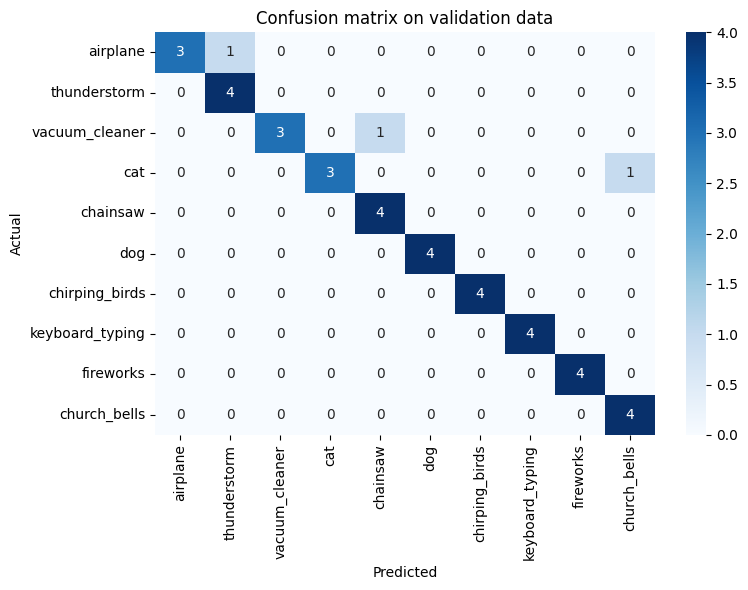

In [12]:
plot_confusion_matrix(
    net, validation_dl, category_map, title="Confusion matrix on validation data"
)

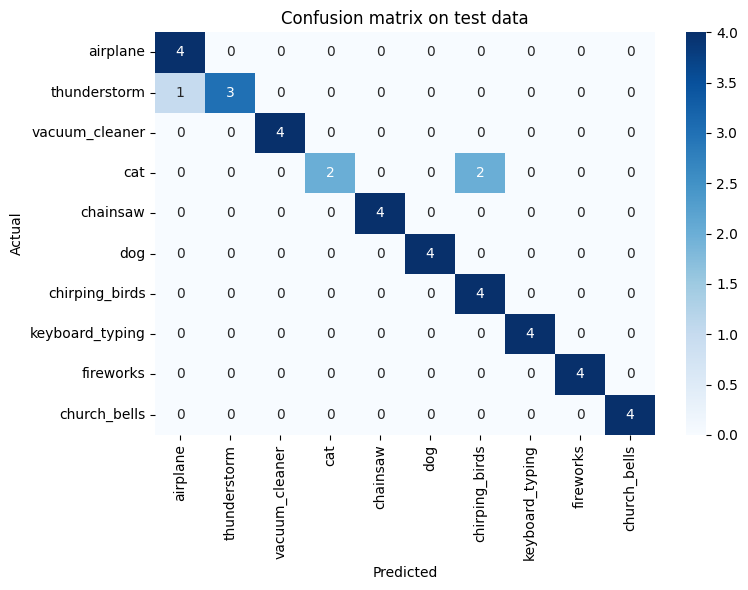

In [13]:
plot_confusion_matrix(net, test_dl, category_map, title="Confusion matrix on test data")